# Определение неэффективных операторов

<div id='0'/>

# Материалы:


[Дашборд](https://public.tableau.com/views/Telecom_16743841392220/Dashboard1?:language=en-US&:display_count=n&:origin=viz_share_link)

Телеком провайдер «Нупозвони» обратился с просьбой помочь им найти неэффективных операторов, и предложить новый сервис для регулярного мониторинга.

Заказчик предоставил датасеты `telecom_clients.csv` и `telecom_dataset.csv` которые описывают использование услуг провайдера виртуальный телефонии «Нупозвони» его клиентами — колл-центрами, которые распределяют входящие вызовы на операторов и совершают исходящие вызовы силами операторов. Операторы также могут делать внутренние вызовы —  вызовы друг между другом внутри сети виртуальной телефонии.

Заказчик ставит задачу определить неэффективных операторов.
В перспективе - предложить новый сервис для регулярного мониторинга.

Признаки низкой эффективности операторов:
- много пропущенных входящих вызовов,
- долгое ожидания ответа при входящих внешних вызовах,
- мало исходящих вывозов — в случае тех колл-центров, что специализируются на обзвонах, а не обработке входящих звонков.

По итогам исследования необходимо подготовить презентацию в формате *.pdf и дашборд, содержащий:
- диаграмму количества вызовов по дням;
- круговую диаграмму, отображающую соотношение кол-ва входящих и исходящих вызовов;
- фильтр дашборда по типу вызова (внешний или внутренний).

# Содержание
- [Материалы](#0)
- [Загрузка и предобработка данных](#1)
- [Исследовательский анализ данных](#2)
- [Решение основных вопросов заказчика](#3)
- [Проверка статистических гипотез](#4)
- [Выводы и рекомендации](#5)

<div id='1'/>

## Загрузка и предобработка данных

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from statsmodels.stats.weightstats import ztest as ztest
import warnings
warnings.filterwarnings('ignore')

In [2]:
clients = pd.read_csv('/datasets/telecom_clients.csv')
clients

,user_id,tariff_plan,date_start
0,166713,A,2019-08-15
1,166901,A,2019-08-23
2,168527,A,2019-10-29
3,167097,A,2019-09-01
4,168193,A,2019-10-16
...,...,...,...
727,166554,B,2019-08-08
728,166911,B,2019-08-23
729,167012,B,2019-08-28
730,166867,B,2019-08-22


In [3]:
# Общая информация о датафрейме
print('Количество дубликатов:', clients.duplicated().sum())
print('Количество пропусков:', clients.isna().sum())
print('Количество тарифных планов:', clients.tariff_plan.nunique())

Количество дубликатов: 0
Количество пропусков: user_id        0
tariff_plan    0
date_start     0
dtype: int64
Количество тарифных планов: 3


In [4]:
clients['date_start'] = pd.to_datetime(clients['date_start'])

In [5]:
dataset = pd.read_csv('/datasets/telecom_dataset.csv')
dataset

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration
0,166377,2019-08-04 00:00:00+03:00,in,False,NaN,True,2,0,4
1,166377,2019-08-05 00:00:00+03:00,out,True,880022.0,True,3,0,5
2,166377,2019-08-05 00:00:00+03:00,out,True,880020.0,True,1,0,1
3,166377,2019-08-05 00:00:00+03:00,out,True,880020.0,False,1,10,18
4,166377,2019-08-05 00:00:00+03:00,out,False,880022.0,True,3,0,25
...,...,...,...,...,...,...,...,...,...
53897,168606,2019-11-10 00:00:00+03:00,out,True,957922.0,True,1,0,38
53898,168606,2019-11-11 00:00:00+03:00,out,True,957922.0,False,2,479,501
53899,168606,2019-11-15 00:00:00+03:00,out,True,957922.0,False,4,3130,3190
53900,168606,2019-11-15 00:00:00+03:00,out,True,957922.0,False,4,3130,3190


In [6]:
dataset.info()
print('Количество дубликатов:', dataset.duplicated().sum())
print('Количество пропусков:', dataset.isna().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53902 entries, 0 to 53901
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   user_id              53902 non-null  int64  
 1   date                 53902 non-null  object 
 2   direction            53902 non-null  object 
 3   internal             53785 non-null  object 
 4   operator_id          45730 non-null  float64
 5   is_missed_call       53902 non-null  bool   
 6   calls_count          53902 non-null  int64  
 7   call_duration        53902 non-null  int64  
 8   total_call_duration  53902 non-null  int64  
dtypes: bool(1), float64(1), int64(4), object(3)
memory usage: 3.3+ MB
Количество дубликатов: 4900
Количество пропусков: user_id                   0
date                      0
direction                 0
internal                117
operator_id            8172
is_missed_call            0
calls_count               0
call_duration            

In [7]:
# Уберем повторяющиеся строки
dataset = dataset.drop_duplicates()

Есть пропуски в колонке operator_id - возможно, это звонки, которые не дождались назначения на оператора и остались неотвеченными. Проверим это.

In [8]:
dataset[dataset['operator_id'].isna()]['is_missed_call'].unique()

array([ True, False])

In [9]:
# Существуют принятые звонки без оператора, значит предположение не подтвердилось
# Это могут быть ошибки в данных, уберем их
dataset = dataset.dropna(axis=0, how='any')

In [10]:
# Посмотрим на даты в массиве
dataset['date'].unique()

array(['2019-08-05 00:00:00+03:00', '2019-08-06 00:00:00+03:00',
       '2019-08-07 00:00:00+03:00', '2019-08-08 00:00:00+03:00',
       '2019-08-09 00:00:00+03:00', '2019-08-12 00:00:00+03:00',
       '2019-08-13 00:00:00+03:00', '2019-08-14 00:00:00+03:00',
       '2019-08-15 00:00:00+03:00', '2019-08-16 00:00:00+03:00',
       '2019-08-19 00:00:00+03:00', '2019-08-20 00:00:00+03:00',
       '2019-08-21 00:00:00+03:00', '2019-08-22 00:00:00+03:00',
       '2019-08-23 00:00:00+03:00', '2019-08-26 00:00:00+03:00',
       '2019-08-27 00:00:00+03:00', '2019-08-28 00:00:00+03:00',
       '2019-08-29 00:00:00+03:00', '2019-08-30 00:00:00+03:00',
       '2019-09-02 00:00:00+03:00', '2019-09-03 00:00:00+03:00',
       '2019-09-04 00:00:00+03:00', '2019-09-05 00:00:00+03:00',
       '2019-09-06 00:00:00+03:00', '2019-09-09 00:00:00+03:00',
       '2019-09-10 00:00:00+03:00', '2019-09-11 00:00:00+03:00',
       '2019-09-12 00:00:00+03:00', '2019-09-13 00:00:00+03:00',
       '2019-09-16 00:00:

In [11]:
# Тут только дни, приведем к нормальному виду (без времени)
dataset['date'] = pd.to_datetime(dataset['date']).dt.date
dataset

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration
1,166377,2019-08-05,out,True,880022.0,True,3,0,5
2,166377,2019-08-05,out,True,880020.0,True,1,0,1
3,166377,2019-08-05,out,True,880020.0,False,1,10,18
4,166377,2019-08-05,out,False,880022.0,True,3,0,25
5,166377,2019-08-05,out,False,880020.0,False,2,3,29
...,...,...,...,...,...,...,...,...,...
53895,168606,2019-11-09,out,False,957922.0,False,4,551,593
53896,168606,2019-11-10,out,True,957922.0,False,1,0,25
53897,168606,2019-11-10,out,True,957922.0,True,1,0,38
53898,168606,2019-11-11,out,True,957922.0,False,2,479,501


In [12]:
# Объединим два датасета (основной и тарифы)
data = dataset.merge(clients, how = 'left', on = 'user_id')
data

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration,tariff_plan,date_start
0,166377,2019-08-05,out,True,880022.0,True,3,0,5,B,2019-08-01
1,166377,2019-08-05,out,True,880020.0,True,1,0,1,B,2019-08-01
2,166377,2019-08-05,out,True,880020.0,False,1,10,18,B,2019-08-01
3,166377,2019-08-05,out,False,880022.0,True,3,0,25,B,2019-08-01
4,166377,2019-08-05,out,False,880020.0,False,2,3,29,B,2019-08-01
...,...,...,...,...,...,...,...,...,...,...,...
41486,168606,2019-11-09,out,False,957922.0,False,4,551,593,C,2019-10-31
41487,168606,2019-11-10,out,True,957922.0,False,1,0,25,C,2019-10-31
41488,168606,2019-11-10,out,True,957922.0,True,1,0,38,C,2019-10-31
41489,168606,2019-11-11,out,True,957922.0,False,2,479,501,C,2019-10-31


In [13]:
# Пропусков в данных нет
data[data['tariff_plan'].isna()]

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration,tariff_plan,date_start


In [14]:
# Статистики, собранной по датам до регистрации компании - нет (иначе было бы похоже на ошибку в данных)
data[data['date']<data['date_start']]

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration,tariff_plan,date_start


Оценим единицы измерения времени в колонках call_duration и total_call_duration. Возьмем среднее значение длительности одного звонка на принятых вызовах.

In [15]:
(data[data['is_missed_call']==False]['call_duration']/data[data['is_missed_call']==False]['calls_count']).mean()

116.65129903184517

Длительность звонков явно в **секундах** - у принятых звонков очень большая длительность, если бы это были минуты.
В сутках 86400 секунд, если суммарная длительность звонков за сутки больше - либо это ошибка. Проверим это.

In [16]:
data[data['total_call_duration']>86400]

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration,tariff_plan,date_start
5197,166582,2019-09-02,out,False,885876.0,False,1018,90095,108665,A,2019-08-09
5204,166582,2019-09-03,out,False,885876.0,False,1137,87700,109600,A,2019-08-09
5210,166582,2019-09-04,out,False,885876.0,False,863,91813,107524,A,2019-08-09
5216,166582,2019-09-05,out,False,885876.0,False,602,109032,120064,A,2019-08-09
5230,166582,2019-09-06,out,False,885876.0,False,584,87556,98711,A,2019-08-09
5246,166582,2019-09-09,out,False,885876.0,False,1138,121093,141930,A,2019-08-09
5253,166582,2019-09-10,out,False,885876.0,False,1053,80782,100139,A,2019-08-09
5260,166582,2019-09-11,out,False,885876.0,False,946,115057,132708,A,2019-08-09
5267,166582,2019-09-12,out,False,885876.0,False,696,125286,138643,A,2019-08-09
5276,166582,2019-09-13,out,False,885876.0,False,652,98748,111703,A,2019-08-09


In [17]:
# Все случаи с аномальной длительностью вызовов на одном операторе, уберем его вообще из выборки
data = data[data['operator_id']!=885876.0]
data

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration,tariff_plan,date_start
0,166377,2019-08-05,out,True,880022.0,True,3,0,5,B,2019-08-01
1,166377,2019-08-05,out,True,880020.0,True,1,0,1,B,2019-08-01
2,166377,2019-08-05,out,True,880020.0,False,1,10,18,B,2019-08-01
3,166377,2019-08-05,out,False,880022.0,True,3,0,25,B,2019-08-01
4,166377,2019-08-05,out,False,880020.0,False,2,3,29,B,2019-08-01
...,...,...,...,...,...,...,...,...,...,...,...
41486,168606,2019-11-09,out,False,957922.0,False,4,551,593,C,2019-10-31
41487,168606,2019-11-10,out,True,957922.0,False,1,0,25,C,2019-10-31
41488,168606,2019-11-10,out,True,957922.0,True,1,0,38,C,2019-10-31
41489,168606,2019-11-11,out,True,957922.0,False,2,479,501,C,2019-10-31


In [18]:
# Если звонок пропущен, то его длительность должна быть равна 0, проверим данные
data[(data['is_missed_call']==True) & (data['call_duration']!=0)]

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration,tariff_plan,date_start
1261,166405,2019-11-19,in,False,939478.0,True,1,165,173,B,2019-08-02
1287,166405,2019-11-21,in,False,882686.0,True,1,1,5,B,2019-08-02
1306,166405,2019-11-22,in,False,882686.0,True,1,1,5,B,2019-08-02
1802,166407,2019-09-23,in,False,888534.0,True,1,133,156,A,2019-08-02
2234,166482,2019-11-05,in,False,934074.0,True,1,1,15,C,2019-08-05
...,...,...,...,...,...,...,...,...,...,...,...
39725,168336,2019-11-01,in,False,947304.0,True,1,1,20,C,2019-10-22
39775,168336,2019-11-12,in,False,947304.0,True,1,69,72,C,2019-10-22
39797,168336,2019-11-15,in,False,947304.0,True,1,46,49,C,2019-10-22
39926,168336,2019-11-27,in,False,958416.0,True,1,40,65,C,2019-10-22


In [19]:
# Уберем такие строки
data = data[~((data['is_missed_call']==True) & (data['call_duration']!=0))]
data

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration,tariff_plan,date_start
0,166377,2019-08-05,out,True,880022.0,True,3,0,5,B,2019-08-01
1,166377,2019-08-05,out,True,880020.0,True,1,0,1,B,2019-08-01
2,166377,2019-08-05,out,True,880020.0,False,1,10,18,B,2019-08-01
3,166377,2019-08-05,out,False,880022.0,True,3,0,25,B,2019-08-01
4,166377,2019-08-05,out,False,880020.0,False,2,3,29,B,2019-08-01
...,...,...,...,...,...,...,...,...,...,...,...
41486,168606,2019-11-09,out,False,957922.0,False,4,551,593,C,2019-10-31
41487,168606,2019-11-10,out,True,957922.0,False,1,0,25,C,2019-10-31
41488,168606,2019-11-10,out,True,957922.0,True,1,0,38,C,2019-10-31
41489,168606,2019-11-11,out,True,957922.0,False,2,479,501,C,2019-10-31


Данные готовы.

### Промежуточный вывод
Исходные данные содержали явно ошибочные значения и значения не имеющие ценности в рамках исследования.
Мы очистили датасет от таких данных. Таблица из 53 тысяч строк сократилась до 41 тысячи.

<div id='2'/>

## Исследовательский анализ данных

### Общая характеристика данных
Анализ количества клиентов - колл-центров и операторов в них

In [20]:
print('Всего операторов:', data['operator_id'].nunique())
print('Всего клиентов (колл-центров):', data['user_id'].nunique())

Всего операторов: 1091
Всего клиентов (колл-центров): 290


Посмотрим на распределение количества операторов по колл-центрам.

In [21]:
company = data[['user_id', 'operator_id']].drop_duplicates()
company = company.groupby(by='user_id').count().reset_index()
company

,user_id,operator_id
0,166377,5
1,166391,2
2,166392,3
3,166399,1
4,166405,10
...,...,...
285,168583,2
286,168598,1
287,168601,2
288,168603,1


In [22]:
company['operator_id'].value_counts()

1     107
2      64
3      33
4      26
5      17
6      10
7       7
8       5
15      3
16      2
9       2
11      2
27      2
30      1
48      1
21      1
28      1
12      1
18      1
17      1
14      1
10      1
50      1
Name: operator_id, dtype: int64

Анализ различных типов звонков

In [23]:
print('Входящие внешние:', data[(data['direction']=='in') & (data['internal']==False)]['calls_count'].sum())
print('Входящие внутренние:', data[(data['direction']=='in') & (data['internal']==True)]['calls_count'].sum())
print('Исходящие внешние:', data[(data['direction']=='out') & (data['internal']==False)]['calls_count'].sum())
print('Исходящие внутренние:', data[(data['direction']=='out') & (data['internal']==True)]['calls_count'].sum())

Входящие внешние: 91683
Входящие внутренние: 675
Исходящие внешние: 536935
Исходящие внутренние: 12892


Сравнение пропущенных и принятых звонков

In [24]:
print('Принятые входящие звонки:', data[(data['is_missed_call']==False) & (data['direction']=='in')]['calls_count'].sum())
print('Непринятые входящие звонки:', data[(data['is_missed_call']==True) & (data['direction']=='in')]['calls_count'].sum())
print('Принятые исходящие звонки:', data[(data['is_missed_call']==False) & (data['direction']=='out')]['calls_count'].sum())
print('Неринятые исходящие звонки:', data[(data['is_missed_call']==True) & (data['direction']=='out')]['calls_count'].sum())

Принятые входящие звонки: 91845
Непринятые входящие звонки: 513
Принятые исходящие звонки: 301823
Неринятые исходящие звонки: 248004


Посмотрим на тарифы, какую информацию несут эти данные. Возможно, они показывают, на каком типе звонков специализируется компания. Дополнительная информация по тарифу представлена в разделе проверки гипотез.

In [25]:
tariff = data[['tariff_plan', 'direction', 'calls_count']]
tariff = tariff.groupby(by = ['tariff_plan', 'direction']).sum().reset_index()[['tariff_plan', 'direction', 'calls_count']]
tariff = pd.pivot_table(tariff,
               index='tariff_plan',
               columns='direction',
               values='calls_count',
               aggfunc='sum').rename_axis(None, axis=1).reset_index().fillna(0)
tariff['in_percent'] = tariff['in']/(tariff['in']+tariff['out'])*100
tariff

,tariff_plan,in,out,in_percent
0,A,30593,289961,9.543790
1,B,28069,110492,20.257504
2,C,33696,149374,18.406074


### Промежуточный вывод
Практически треть компаний, которые есть в исходных данных, имеют у себя в штате только одного оператора. Если для выходящих вызовов, их можно будет сравнивать, то с случае с исходящими, надо будет подумать о какой-то классификации компаний, если это возможно.

Входящие внутренние звонки составляют небольшую часть от общего объема входящих. А вот количество исходящих внутренних одного порядка с входящими внешними, надо будет это учесть при определении неэффективных операторов - нет ли тех, кто очень много звонит.

Количество непринятых выходящих в 100 раз меньше количества принятых. Значит, это не массовая проблема, тогда, возможно определить неэффективных сотрудников по данному критерию.

Количество принятых и непринятых исходящих довольно близко, что понятно - разные типы звонков и разные типы клиентов.

По данным нет возможности сделать вывод, на что конкретно влияет тариф. Дополнительная информация по тарифу представлена в разделе проверки гипотез.

<div id='3'/>

## Решение основных вопросов заказчика

### Определение типа компании по основному направлению вызовов

В качестве клиентов могут быть колл-центры, которые обрабатывают входящие вызовы, а могут быть те, кто занимаются холодными и горячими обзвонами. Определим списки этих колл-центром и будем по ним применять различные критерии эффективности.

In [26]:
# Внутренние вызовы тут не нужны
d = data[data['internal']==False].groupby(by = ['user_id', 'direction']).sum().reset_index()[['user_id', 'direction', 'calls_count']]
d = pd.pivot_table(d,
               index='user_id',
               columns='direction',
               values='calls_count',
               aggfunc='sum').rename_axis(None, axis=1).reset_index().fillna(0)
d['in_percent'] = d['in']/(d['in']+d['out'])*100
d

,user_id,in,out,in_percent
0,166377,102.0,4897.0,2.040408
1,166391,4.0,0.0,100.000000
2,166392,102.0,0.0,100.000000
3,166399,11.0,0.0,100.000000
4,166405,2188.0,9789.0,18.268348
...,...,...,...,...
285,168583,22.0,0.0,100.000000
286,168598,21.0,0.0,100.000000
287,168601,79.0,586.0,11.879699
288,168603,0.0,14.0,0.000000


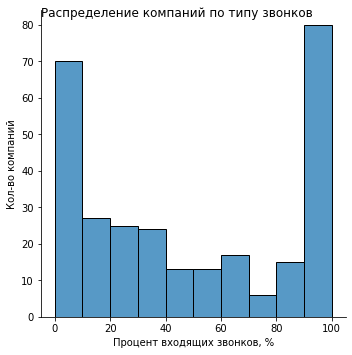

In [27]:
d_graph = sns.displot(x='in_percent', data=d)
d_graph.set(xlabel='Процент входящих звонков, %', ylabel='Кол-во компаний')
d_graph.fig.suptitle('Распределение компаний по типу звонков')
plt.show()

Построим график распределения процента входящих звонков по компаниям, чтобы понять, насколько четкая граница разделения.
Есть достаточно большое количество компаний, в которых явно преобладает какой-либо тип звонков. Но при этом, в части компаний, зачастую в равной степени, представлены оба типа звонков. Посмотрим на них подробнее.

In [28]:
mixed_list = d[(d['in_percent']>40) & (d['in_percent']<60)]['user_id'].unique()
mixed_list

array([166717, 166732, 166813, 166916, 166946, 167016, 167113, 167235,
       167246, 167263, 167397, 167445, 167466, 167543, 167630, 167650,
       167742, 167799, 167829, 167969, 167977, 168008, 168180, 168185,
       168271, 168275])

In [29]:
data[data['user_id'].isin(mixed_list)].groupby(by = 'user_id').sum().reset_index()[['user_id', 'calls_count']]

,user_id,calls_count
0,166717,888
1,166732,109
2,166813,74
3,166916,5750
4,166946,112
5,167016,1820
6,167113,2
7,167235,1756
8,167246,150
9,167263,16


У части таких компаний довольно много звонков.
Определим границу деления компаний - по 50% типов звонков.

In [30]:
in_list = d[(d['in_percent']>50)]['user_id'].unique()
out_list = d[(d['in_percent']<50)]['user_id'].unique()

### Определение неэффективных операторов на входящих вызовах

Сначала посмотрим, сколько вообще входящих вызовов было у операторов в целом. Будем смотреть и на внешние, и на внутренние, потому что операторы должны хорошо отвечать и на вопросы коллег. Ненужные столбцы столбцы удалим.

In [31]:
incoming = data[(data['direction']=='in') & (data['user_id'].isin(in_list))][['user_id', 'date', 'operator_id', 'is_missed_call', 'calls_count', 'call_duration', 'total_call_duration']]
incoming

,user_id,date,operator_id,is_missed_call,calls_count,call_duration,total_call_duration
482,166391,2019-08-06,882476.0,False,1,175,186
483,166391,2019-08-07,882478.0,False,2,11,74
484,166391,2019-08-07,882478.0,False,1,57,70
486,166391,2019-09-23,882476.0,False,1,4,24
487,166391,2019-11-22,882476.0,False,1,13,77
...,...,...,...,...,...,...,...
41417,168598,2019-11-20,958394.0,False,1,16,21
41418,168598,2019-11-21,958394.0,False,1,15,22
41419,168598,2019-11-25,958394.0,False,4,2108,2134
41420,168598,2019-11-27,958394.0,False,2,89,100


In [32]:
# Суммарное число звонков на оператора
sum_inc = incoming.groupby(by=['operator_id']).sum().reset_index()[['operator_id', 'calls_count']].sort_values(by='calls_count')
sum_inc

,operator_id,calls_count
66,904344.0,1
126,913886.0,1
220,945710.0,1
221,946468.0,1
115,911104.0,1
...,...,...
134,919554.0,1170
135,919790.0,1576
128,913942.0,2426
244,952948.0,3540


У некоторых операторов довольно мало звонков - они могут только начинать работать или же их основная работа на исходящих звонках. 
Интересно посмотреть на то, есть ли зависимость между кол-вом звонков и метрикой эффективности, например, числом пропущенных вызовов.

#### Определяем неэффективных по числу пропущенных вызовов

In [33]:
incoming_amount = incoming[['operator_id', 'is_missed_call', 'calls_count']]
incoming_amount

,operator_id,is_missed_call,calls_count
482,882476.0,False,1
483,882478.0,False,2
484,882478.0,False,1
486,882476.0,False,1
487,882476.0,False,1
...,...,...,...
41417,958394.0,False,1
41418,958394.0,False,1
41419,958394.0,False,4
41420,958394.0,False,2


Посчитаем процент непринятых звонков

In [34]:
# Делаем сводную таблицу по суммарному числу пропущенных и принятых вызовов на человека
part_miss = pd.pivot_table(incoming_amount,
               index='operator_id',
               columns='is_missed_call',
               values='calls_count',
               aggfunc='sum').rename_axis(None, axis=1).reset_index().fillna(0).rename(columns = {0: 'not_missed', 1: 'missed'})
part_miss['sum'] = part_miss['not_missed']+part_miss['missed']
part_miss['missed_percent'] = part_miss['missed']/part_miss['sum']*100
part_miss

,operator_id,not_missed,missed,sum,missed_percent
0,882476.0,3.0,0.0,3.0,0.000000
1,882478.0,3.0,0.0,3.0,0.000000
2,882680.0,96.0,3.0,99.0,3.030303
3,884294.0,1.0,0.0,1.0,0.000000
4,886674.0,11.0,0.0,11.0,0.000000
...,...,...,...,...,...
271,969294.0,84.0,0.0,84.0,0.000000
272,971100.0,3.0,0.0,3.0,0.000000
273,971102.0,76.0,0.0,76.0,0.000000
274,971354.0,6.0,0.0,6.0,0.000000


In [35]:
part_miss['missed_percent'].describe()

count    276.000000
mean       0.980709
std        3.640836
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max       33.333333
Name: missed_percent, dtype: float64

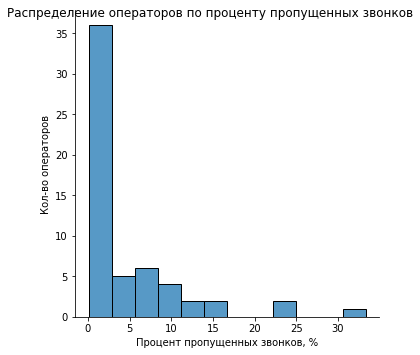

In [36]:
d_graph = sns.displot(x='missed_percent', data=part_miss[part_miss['missed_percent']>0])
d_graph.set(xlabel='Процент пропущенных звонков, %', ylabel='Кол-во операторов')
d_graph.fig.suptitle('Распределение операторов по проценту пропущенных звонков')
plt.show()

Большая часть операторов отвечает на все или практически на все звонки, которые им приходят. Поставим границу в 7% непринятых звонков - будем считать, что в эти 7% будут входить технические проблемы и случаи, когда человек позвонил и сразу же сбросил трубку.

In [37]:
bad_list = part_miss[part_miss['missed_percent']>=7]['operator_id'].unique()
bad_list

array([888406., 896538., 905300., 905862., 911102., 911142., 918888.,
       926872., 930242., 934076., 934098., 944216., 944222., 944226.])

#### Определяем неэффективных по времени ответа

Время ожидания можно понимать двумя способами:
1. Время от начала звонка клиента до ответа оператора, которое включает в себя то время, когда все операторы были заняты и не могли ответить физически.
2. Время от назначения звонка на конкретного оператора, когда он уже освободился, до ответа.

В первом случае возможна ситуация, когда звонков сильно больше, чем операторов, которые могут ответить на них и тогда измерять эффективность сотрудников по времени ожидания бесполезно - клиент просто будет долго ждать ответа и не получит его, а вины сотрудника в этом нет.
Во втором же случае можно анализировать.

Скорее всего, мы имеем дело со вторым случаем, потому что если звонок только поступил и нет свободных операторов, он вряд ли будет назначаться на какого-то конкретного человека, пока кто-то не освободится. 
Про звонки без операторов был разбор выше, их тут нет.

In [38]:
# Вводим время ожидания
incoming['waiting_time'] = incoming['total_call_duration'] - incoming['call_duration']
incoming

,user_id,date,operator_id,is_missed_call,calls_count,call_duration,total_call_duration,waiting_time
482,166391,2019-08-06,882476.0,False,1,175,186,11
483,166391,2019-08-07,882478.0,False,2,11,74,63
484,166391,2019-08-07,882478.0,False,1,57,70,13
486,166391,2019-09-23,882476.0,False,1,4,24,20
487,166391,2019-11-22,882476.0,False,1,13,77,64
...,...,...,...,...,...,...,...,...
41417,168598,2019-11-20,958394.0,False,1,16,21,5
41418,168598,2019-11-21,958394.0,False,1,15,22,7
41419,168598,2019-11-25,958394.0,False,4,2108,2134,26
41420,168598,2019-11-27,958394.0,False,2,89,100,11


В этом датафрейме операторы, у которых есть 10 и более вызовов. Посчитаем среднее время ожидания на 1 вызов.

In [39]:
part_long = incoming.groupby(by='operator_id').sum().reset_index()[['operator_id', 'calls_count', 'waiting_time']]
part_long['mean_waiting_time'] = part_long['waiting_time']/part_long['calls_count']
part_long

,operator_id,calls_count,waiting_time,mean_waiting_time
0,882476.0,3,95,31.666667
1,882478.0,3,76,25.333333
2,882680.0,99,1591,16.070707
3,884294.0,1,6,6.000000
4,886674.0,11,168,15.272727
...,...,...,...,...
271,969294.0,84,710,8.452381
272,971100.0,3,26,8.666667
273,971102.0,76,1352,17.789474
274,971354.0,6,84,14.000000


In [40]:
part_long['mean_waiting_time'].describe()

count    276.000000
mean      18.899320
std       10.807540
min        0.791667
25%       11.980627
50%       16.650000
75%       25.083333
max       58.000000
Name: mean_waiting_time, dtype: float64

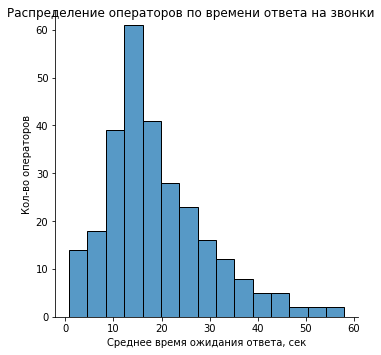

In [41]:
d_graph = sns.displot(x='mean_waiting_time', data=part_long)
d_graph.set(xlabel='Среднее время ожидания ответа, сек', ylabel='Кол-во операторов')
d_graph.fig.suptitle('Распределение операторов по времени ответа на звонки')
plt.show()

Фактически клиенты уже ждут какое-то время до назначения на оператора (при правильном планировании численности операторов, это не должно быть большое время), и этого времени нет данных. Потом ждут ответа оператора и время на работу системы (дадим на него 5 сек). Обычно колл-центры стремятся отвечать за 20-30 секунд, так что отведем на время ответа оператора и работу системы 25 сек.

График распределения времени ожидания показывает, что большинство операторов уже подходят под эти нормы.

In [42]:
# Определим тех, у кого 25 сек среднее время ожидания и более, как неэффективных и внесем в список
bad_list1 = part_long[part_long['mean_waiting_time']>=25]['operator_id'].unique()
bad_list1

array([882476., 882478., 886892., 888406., 891900., 891906., 891918.,
       896018., 896538., 898558., 898560., 899892., 899898., 899900.,
       900792., 901350., 901498., 902910., 903512., 905478., 906070.,
       906076., 906394., 906396., 906400., 906402., 906404., 906406.,
       906408., 906410., 908834., 908958., 909768., 910958., 911102.,
       911140., 911142., 912684., 919552., 919554., 919790., 919792.,
       919794., 920874., 920982., 922356., 927070., 929340., 933832.,
       933996., 934076., 934098., 934424., 934430., 934432., 944210.,
       944216., 944218., 944220., 944222., 944226., 944228., 944246.,
       944474., 946468., 951118., 951332., 952292., 952678., 955164.,
       969288., 973286.])

### Определяем неэффективных по соотношению принятых и переадресованных звонков

Если сотрудник переадресует значительную чатсь звонков, либо по знаичтельной части звонков обращается за помозью к коллегам, его можно считать неэффективным. Проверим таких сотрудников.

In [43]:
transfer = data[((data['direction']=='in') & (data['is_missed_call']==False) & (data['internal'] == False)) |\
               ((data['direction']=='out') & (data['is_missed_call']==False) & (data['internal'] == True)) & (data['user_id'].isin(in_list))][['operator_id', 'direction', 'calls_count']]
transfer = transfer.groupby(by=['operator_id', 'direction']).sum().reset_index().sort_values(by='calls_count')
transfer

,operator_id,direction,calls_count
317,913886.0,in,1
109,896430.0,in,1
200,905472.0,in,1
202,905478.0,in,1
718,955086.0,out,1
...,...,...,...
392,921318.0,in,2312
320,913942.0,in,2415
80,893804.0,in,2417
701,952948.0,in,3532


In [44]:
# Делаем сводную таблицу по суммарному числу принятых и переадресованных
part_transfer = pd.pivot_table(transfer,
               index='operator_id',
               columns='direction',
               values='calls_count',
               aggfunc='sum').rename_axis(None, axis=1).reset_index().fillna(0)
part_transfer['over'] = part_transfer['out']/part_transfer['in']
# Уберем то, где есть исходящие внутренние, но нет входящих внешних - это что-то непонятное
part_transfer = part_transfer[part_transfer['over']!=np.inf]
part_transfer.sort_values(by='over')

,operator_id,in,out,over
0,879896.0,58.0,0.0,0.000000
485,936382.0,1.0,0.0,0.000000
486,936514.0,74.0,0.0,0.000000
487,936984.0,70.0,0.0,0.000000
488,937362.0,5.0,0.0,0.000000
...,...,...,...,...
234,907970.0,16.0,134.0,8.375000
210,906394.0,30.0,282.0,9.400000
219,906412.0,19.0,182.0,9.578947
220,906416.0,5.0,51.0,10.200000


In [45]:
part_transfer['over'].describe()

count    736.000000
mean       0.620972
std       14.501931
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max      393.000000
Name: over, dtype: float64

Очень мало тех, у кого количество внутренних исходящих звонков сравнимо с входящими, но есть и те, у кого их даже больше. 
Внесем в список тех, у кого число внутренних составляет 50% от внешних - то есть в половине случаев идет переадресация или консультация.

In [46]:
bad_list2 = part_transfer[part_transfer['over']>=0.5]['operator_id'].unique()
bad_list2

array([893400., 905472., 906394., 906396., 906400., 906402., 906412.,
       906416., 906420., 907504., 907952., 907964., 907970., 907982.,
       907986., 907994., 921104., 952196.])

### Определение неэффективных операторов на исходящих вызовах

Нужно определить тех, кто совершает мало исходящих вывозов — в случае тех колл-центров, что специализируются на обзвонах, а не обработке входящих звонков.

Внутри разных компаний может быть разное кол-во исходящих вызовов за день. Посмотрим, насколько сильно они отличаются.

In [47]:
# Нас не интересует совершение внутренних звонков, не интересует ответили ли на звонок и сколько он длился
outcoming = data[(data['direction']=='out') & (data['internal']==False) & (data['user_id'].isin(out_list))][['user_id', 'date', 'operator_id', 'calls_count']]
outcoming = outcoming.groupby(by=['user_id', 'date', 'operator_id']).sum().reset_index()
outcoming

,user_id,date,operator_id,calls_count
0,166377,2019-08-05,880020.0,10
1,166377,2019-08-05,880022.0,3
2,166377,2019-08-06,880020.0,10
3,166377,2019-08-06,881278.0,3
4,166377,2019-08-07,880020.0,2
...,...,...,...,...
12351,168603,2019-11-20,959118.0,6
12352,168603,2019-11-21,959118.0,6
12353,168603,2019-11-27,959118.0,1
12354,168606,2019-11-08,957922.0,4


In [48]:
mean_out = outcoming.groupby(by=['user_id']).mean().reset_index().sort_values(by='calls_count')[['user_id', 'calls_count']]
mean_out

,user_id,calls_count
81,167364,1.000000
8,166507,1.500000
32,166813,1.629630
78,167288,2.000000
52,167012,2.000000
...,...,...
129,168025,131.531250
126,168018,176.057143
114,167827,363.598131
77,167285,749.157895


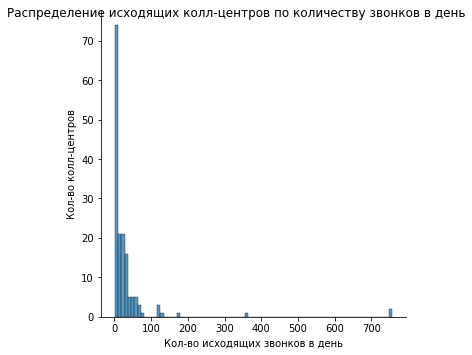

In [49]:
d_graph = sns.displot(x='calls_count', data=mean_out)
d_graph.set(xlabel='Кол-во исходящих звонков в день', ylabel='Кол-во колл-центров')
d_graph.fig.suptitle('Распределение исходящих колл-центров по количеству звонков в день')
plt.show()

Компании совершают различное число исходящих звонков, а значит сравнивать сотрудников между компаниями - неправильно, надо сравнивать внутри одной компании. Берем среднее число звонков в день (если один сотрудник работал больше дней, чем другой, то у него будет и больше звонков, но это не значит, что он более эффективный).

Надо понять, какое число звонков считать нормой. Это параметр, который устанавливает сама компания. Если мы просто возьмем какой-то перцентиль, то таким образом получим топ худших сотрудников, но не обязательно самых неэффективных.

Можно взять медианное значение и поделить его на 2 - тогда мы сразу увидим тех, кто очень сильно выделяется по сравнению с остальными.

In [50]:
part_out = outcoming.groupby(by=['user_id', 'operator_id']).mean().reset_index()[['user_id', 'operator_id', 'calls_count']]
part_out = part_out.sort_values(by=['user_id', 'calls_count'])
part_out

,user_id,operator_id,calls_count
4,166377,881278.0,2.400000
1,166377,880022.0,4.833333
0,166377,880020.0,4.857143
2,166377,880026.0,28.415584
3,166377,880028.0,31.910256
...,...,...,...
699,168481,959596.0,9.000000
701,168601,952916.0,1.750000
700,168601,952914.0,30.473684
702,168603,959118.0,3.500000


In [51]:
part_out1 = outcoming.groupby(by=['user_id']).quantile(.5).reset_index()[['user_id', 'calls_count']].rename(columns={'calls_count': 'threshold'})
part_out1['threshold'] = part_out1['threshold']/2
part_out1

,user_id,threshold
0,166377,13.00
1,166405,8.50
2,166406,26.00
3,166407,1.00
4,166485,8.00
...,...,...
154,168473,4.00
155,168481,2.25
156,168601,9.00
157,168603,1.75


In [52]:
part_out = part_out.merge(part_out1, on = 'user_id')
part_out

,user_id,operator_id,calls_count,threshold
0,166377,881278.0,2.400000,13.00
1,166377,880022.0,4.833333,13.00
2,166377,880020.0,4.857143,13.00
3,166377,880026.0,28.415584,13.00
4,166377,880028.0,31.910256,13.00
...,...,...,...,...
699,168481,959596.0,9.000000,2.25
700,168601,952916.0,1.750000,9.00
701,168601,952914.0,30.473684,9.00
702,168603,959118.0,3.500000,1.75


In [53]:
bad_list3 = part_out[part_out['calls_count']<part_out['threshold']]['operator_id'].unique()
bad_list3

array([881278., 880022., 880020., 939478., 880240., 879896., 887280.,
       887278., 884402., 891416., 885682., 890234., 891192., 930510.,
       947480., 939236., 910902., 890232., 923254., 930524., 910926.,
       897894., 900192., 900194., 891156., 891166., 891158., 891162.,
       891152., 891744., 919418., 950444., 932088., 972408., 915614.,
       908984., 891746., 916596., 891250., 895266., 917890., 894662.,
       914626., 909134., 903312., 898902., 899972., 930910., 930908.,
       933452., 942174., 951650., 901996., 905570., 905574., 905840.,
       905934., 932246., 914348., 957022., 913984., 919536., 924370.,
       914256., 914272., 914266., 961552., 935956., 921814., 944648.,
       952656., 914240., 918958., 924932., 924928., 919214., 937362.,
       937366., 937368., 960670., 956298., 919206., 919164., 919204.,
       919166., 928228., 919910., 919190., 925134., 921320., 921306.,
       918988., 922486., 940436., 940440., 929884., 929876., 930186.,
       945898., 9380

### Сотрудники с долгим ожиданием на исходящих звонках

Возможный способ обмана системы - это включить исходящий вызов и держать его долгое время, без ответа клиента, а в это время не работать. Проверим такие случаи.

Слишком быстрый сброс при исходящем звонке тоже можно было бы считать неэффективностью, но возможны случаи, когда исходящий номер оказался в ЧС или когда настроена какая-то переадресация, поэтому их рассматривать не будем.

Поставим фильтр is_missed_call==True - тогда в суммарном времени диалога будет только ожидание.

In [54]:
long_outcoming = data[(data['direction']=='out') & (data['internal']==False) & (data['is_missed_call']==True)][['operator_id', 'calls_count', 'total_call_duration']]
long_outcoming = long_outcoming.groupby(by=['operator_id']).sum().reset_index()
long_outcoming

,operator_id,calls_count,total_call_duration
0,879896.0,220,5626
1,879898.0,2345,49701
2,880020.0,19,135
3,880022.0,90,3102
4,880026.0,628,12239
...,...,...,...
767,972408.0,2,30
768,972410.0,37,1042
769,972412.0,25,582
770,972460.0,26,346


Возьмем тех, у кого больше 10 вызовов и посчитаем среднюю длительность.

In [55]:
long_outcoming = long_outcoming[long_outcoming['calls_count']>10]
long_outcoming['mean_wait'] = long_outcoming['total_call_duration']/long_outcoming['calls_count']
long_outcoming.sort_values(by='mean_wait')

,operator_id,calls_count,total_call_duration,mean_wait
631,946454.0,13,0,0.000000
381,924614.0,16,16,1.000000
106,898422.0,11,46,4.181818
255,914238.0,15,66,4.400000
519,938414.0,27,130,4.814815
...,...,...,...,...
489,937782.0,14,498,35.571429
400,926312.0,76,2844,37.421053
123,900194.0,19,785,41.315789
483,937762.0,75,3106,41.413333


Самое большое среднее время ожидания - 44 секунды, не выглядит как что-то ненормальное. В данной таблице неэффективных сотрудников по такому параметру нет, но проверку можно оставить на будущее.

### Итоговый лист неэффективных сотрудников

In [56]:
bad_list_final = np.append(bad_list, bad_list1)
bad_list_final = np.append(bad_list_final, bad_list2)
bad_list_final = np.append(bad_list_final, bad_list3)
# Наверняка в списках по разным критериям попали одни и те же люди - удалим повторы
bad_list_final = np.unique(bad_list_final)
bad_list_final

array([879896., 880020., 880022., 880240., 881278., 882476., 882478.,
       884402., 885682., 886892., 887278., 887280., 888406., 890232.,
       890234., 891152., 891156., 891158., 891162., 891166., 891192.,
       891250., 891416., 891744., 891746., 891900., 891906., 891918.,
       893400., 894662., 895266., 896018., 896538., 897894., 898558.,
       898560., 898902., 899892., 899898., 899900., 899972., 900192.,
       900194., 900792., 901350., 901498., 901996., 902910., 903312.,
       903512., 905300., 905472., 905478., 905570., 905574., 905840.,
       905862., 905934., 906070., 906076., 906394., 906396., 906400.,
       906402., 906404., 906406., 906408., 906410., 906412., 906416.,
       906420., 907504., 907952., 907964., 907970., 907982., 907986.,
       907994., 908834., 908958., 908984., 909134., 909768., 910902.,
       910926., 910958., 911102., 911140., 911142., 912684., 913984.,
       914240., 914256., 914266., 914272., 914348., 914626., 915614.,
       916596., 9178

In [57]:
print('Всего операторов:', data['operator_id'].nunique())
print('Неэффективных операторов:', len(bad_list_final))
print('Процент неэффективных операторов:', len(bad_list_final)/data['operator_id'].nunique()*100)

Всего операторов: 1091
Неэффективных операторов: 251
Процент неэффективных операторов: 23.006416131989003


Посмотрим в разрезе колл-центров

In [58]:
company = data[['user_id', 'operator_id']].drop_duplicates()
company = company[company['operator_id'].isin(bad_list_final)]
company

,user_id,operator_id
0,166377,880022.0
1,166377,880020.0
6,166377,881278.0
482,166391,882476.0
483,166391,882478.0
...,...,...
41060,168412,953460.0
41365,168481,956292.0
41374,168500,952196.0
41399,168579,973286.0


In [59]:
print('Всего компаний:', data['user_id'].nunique())
print('Всего компаний с неэффективными сотрудниками:', company['user_id'].nunique())
print('Процент компаний с неэффективными сотрудниками:', company['user_id'].nunique()/data['user_id'].nunique()*100)

Всего компаний: 290
Всего компаний с неэффективными сотрудниками: 103
Процент компаний с неэффективными сотрудниками: 35.51724137931034


In [60]:
# В каких компаниях наибольшее количество неэффективных сотрудников
company['user_id'].value_counts()

168187    19
166520    12
168062    11
166916    11
168252    11
          ..
167009     1
167286     1
167003     1
168025     1
167275     1
Name: user_id, Length: 103, dtype: int64

In [61]:
# Сколько всего сотрудников в тех компаниях, где есть неэффективные сотрудники
data[data['user_id'].isin(company['user_id'].unique())][['user_id', 'operator_id']].drop_duplicates()

,user_id,operator_id
0,166377,880022.0
1,166377,880020.0
6,166377,881278.0
10,166377,880028.0
11,166377,880026.0
...,...,...
41374,168500,952196.0
41388,168579,954810.0
41399,168579,973286.0
41422,168601,952914.0


### Промежуточный вывод
По тем числовым границам, которые мы определили, был найден 251 неэффективный сотрудник, что составляет 23% от суммарного штата операторов у клиентов. 
Больше трети клиентов имеют в своем штате неэффективных сотрудников.

<div id='4'/>

## Проверка статистических гипотез

### Сравнение тарифов

В ходе определения эффективности сотрудников по времени ответа, было предположение, что все компании стремятся к максимально быстрым ответам на звонки.  Проверим, существет ли разница в среднем времени ожидания ответа в колл-центрах на трех тарифах, которые представленны в данных.


H_0: Различий в среднем времени ответа между компаниями на 3 тарифах нет

H_1: Различия в среднем времени ответа между компаниями на 3 тарифах есть

In [62]:
# Датафрейм с входящими вызовами
incoming_test = incoming.copy().merge(clients, how = 'left', on = 'user_id')[['user_id', 'calls_count', 'waiting_time', 'tariff_plan']]
incoming_test

,user_id,calls_count,waiting_time,tariff_plan
0,166391,1,11,C
1,166391,2,63,C
2,166391,1,13,C
3,166391,1,20,C
4,166391,1,64,C
...,...,...,...,...
4428,168598,1,5,C
4429,168598,1,7,C
4430,168598,4,26,C
4431,168598,2,11,C


In [63]:
incoming_test = incoming_test.groupby(by=['user_id', 'tariff_plan']).sum().reset_index()
incoming_test['mean_wait'] = incoming_test['waiting_time']/incoming_test['calls_count']
incoming_test

,user_id,tariff_plan,calls_count,waiting_time,mean_wait
0,166391,C,6,171,28.500000
1,166392,C,102,3080,30.196078
2,166399,C,11,168,15.272727
3,166428,B,126,1978,15.698413
4,166481,A,1,6,6.000000
...,...,...,...,...,...
122,168562,B,6,101,16.833333
123,168575,C,8,100,12.500000
124,168579,B,39,424,10.871795
125,168583,B,22,305,13.863636


In [64]:
A = incoming_test[incoming_test['tariff_plan']=='A']['mean_wait']
B = incoming_test[incoming_test['tariff_plan']=='B']['mean_wait']
C = incoming_test[incoming_test['tariff_plan']=='C']['mean_wait']

Для проверки гипотезы, можно сделать три попарных проверки гипотез следующего типа:

H_0: Различий в среднем времени ответа между компаниями на 2 тарифах нет

H_1: Различия в среднем времени ответа между компаниями на 2 тарифах есть

Если все три нулевых гипотез не получится опровергнуть, то не получится опревергнуть и основную.
Если хотя бы одну нулевую гипотезу получится опровергнуть, то опровергнется и основная.

Выборка меньше чем из 100 элементов - возьмем уровень значимости 0.05 и применим z-тест

In [65]:
print(ztest(A, B, value=0.05))
print(ztest(B, C, value=0.05))
print(ztest(C, A, value=0.05))

(-0.4775495311257629, 0.6329708592311722)
(-0.24157441179212108, 0.8091099513353294)
(0.6812309051751039, 0.495725395497311)


Значение pvalue во всех трех случаях значительно превосходит 0.05.

Не получилось отвергнуть нулевую гипотезу, - различий в среднем времени ответа между компаниями на тарифах A, B и C нет.

### Связь количества звонков с процентом пропущенных звонков

Важно понять, есть ли связь между количеством входящих звонков в целом и количеством пропущенных звонков.
Если она есть, то имеет смысл установить некоторый барьер по количеству звонков на оператора, чтобы критерии эффективности были более правильными.
Если связи нет, то такой барьер ставить не надо.


H_0: Между количеством пропущенных вызовов и количеством входящих вызовов в целом нет зависимости

H_1: Между количеством пропущенных вызовов и количеством входящих вызовов в целом есть зависимость

In [66]:
part_miss

,operator_id,not_missed,missed,sum,missed_percent
0,882476.0,3.0,0.0,3.0,0.000000
1,882478.0,3.0,0.0,3.0,0.000000
2,882680.0,96.0,3.0,99.0,3.030303
3,884294.0,1.0,0.0,1.0,0.000000
4,886674.0,11.0,0.0,11.0,0.000000
...,...,...,...,...,...
271,969294.0,84.0,0.0,84.0,0.000000
272,971100.0,3.0,0.0,3.0,0.000000
273,971102.0,76.0,0.0,76.0,0.000000
274,971354.0,6.0,0.0,6.0,0.000000


Выборка из 276 операторов, посчитаем корреляцию Пирсона с уровнем значимости 0.01

In [67]:
stats.pearsonr(part_miss['sum'], part_miss['missed_percent'])

PearsonRResult(statistic=-0.02281045518884566, pvalue=0.7059618419737279)

Значение pvalue значительно превосходит 0.01.

Не получилось отвергнуть нулевую гипотезу, - Между количеством пропущенных вызовов и количеством входящих вызовов в целом нет зависимости.
Следовательно нет необходимости вводить ограничения на количество вызовов на оператора.

<div id='5'/>

## Выводы и рекомендации

В результате данного исследования, было определено 5 критериев, по которым можно определять эффективность сотрудников колл-центра. 3 из них относятся к входящей линии, 2 к исходящей.

По тем числовым границам, которые мы определили, был найден 251 неэффективный сотрудник, что составляет 23% от суммарного штата операторов у клиентов. 
Больше трети клиентов имеют в своем штате неэффективных сотрудников.

Исходя из этого, можно сделать вывод, что система мониторинга операторов может быть интересна клиентам, поскольку уже на данном этапе указывает на значительную часть неэффективных сотрудников.

В целом, численные критерии эффективности будут подходить любому колл-центру, но более правильным будет дать возможность клиентам самим устанавливать границы (например, по времени ответа). Несмотря на то, что большинство клиентов имеет примерно одинаковые показатели, в частных случаях могут быть изменения.
Например, крупной компании с большим штатом операторов может быть важно установить более качественный уровень обслуживания, то есть поставить более строгие критерии для сотрудников, а значит данная система будет еще более актуальна и востребована.